In [1]:
from IPython.display import Image 

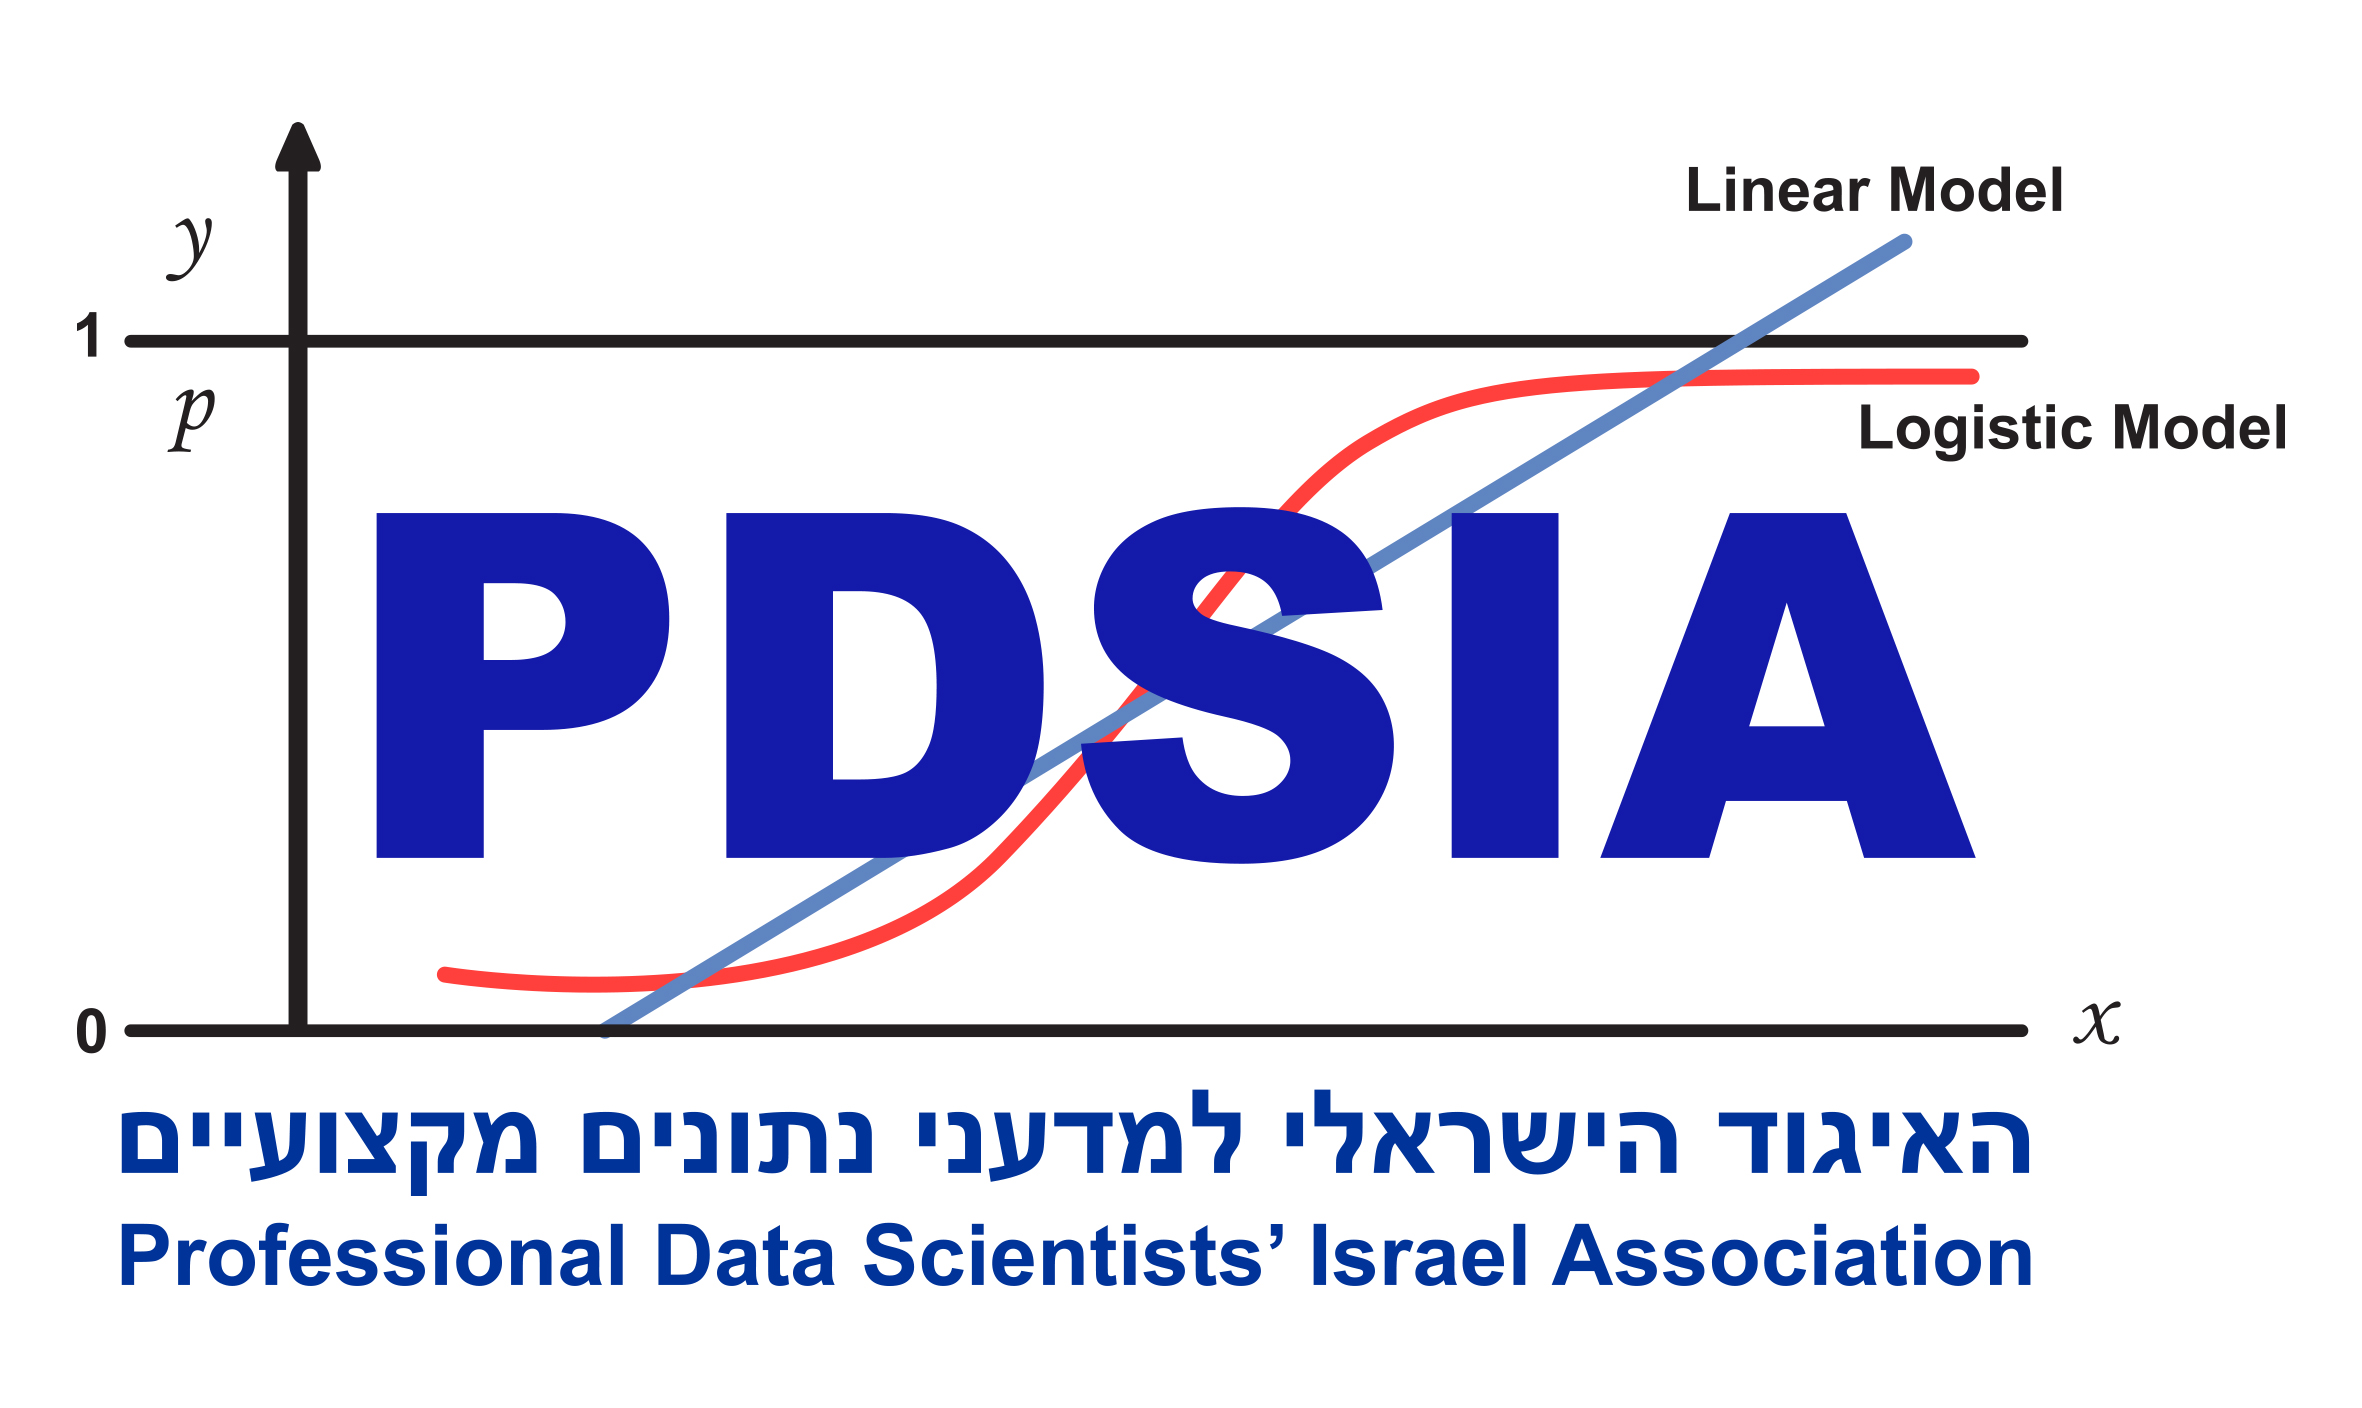

In [2]:
Image(filename='logo.jpg')

# Motivation

The dataset comes from MAFAT, and it is related to The data contains I/Q signals of humans or animals collected by radar sensors in different locations and times. The classification goal is to predict whether the radar track is a human (1) or an animal (0) (variable y). 

# Data

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

The dataset contains I/Q signals of humans or animals collected by radar sensors in different locations and times. It includes 106610 records and 8 fields.

In [4]:
train = pd.read_csv('MAFAT RADAR Challenge - Public Training Set V1.csv')
train = train.dropna()
print(train.shape)
print(list(train.columns))

(71428, 8)
['segment_id', 'track_id', 'geolocation_type', 'geolocation_id', 'sensor_id', 'snr_type', 'date_index', 'target_type']


In [5]:
test = pd.read_csv('MAFAT RADAR Challenge - Public Test Set V1.csv')
test = test.dropna()
print(test.shape)
print(list(test.columns))

(35182, 8)
['segment_id', 'track_id', 'geolocation_type', 'geolocation_id', 'sensor_id', 'snr_type', 'date_index', 'target_type']


In [6]:
train.head()

,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type
0,2031308,255007,D,6,8,SynthSNR,2,human
1,2061729,279536,D,7,13,SynthSNR,3,human
2,39921,260948,D,6,10,HighSNR,2,human
3,2050469,267615,D,7,12,SynthSNR,3,human
4,2019816,249620,C,5,5,SynthSNR,4,human


In [7]:
test.head()

,segment_id,track_id,geolocation_type,geolocation_id,sensor_id,snr_type,date_index,target_type
0,2043932,262104,D,6,10,SynthSNR,2,human
1,2059527,277754,D,7,13,SynthSNR,3,human
2,28947,253645,C,5,7,HighSNR,4,human
3,53344,270761,D,7,12,HighSNR,3,human
4,2020216,249911,C,5,5,SynthSNR,4,human


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71428 entries, 0 to 71427
Data columns (total 8 columns):
segment_id          71428 non-null int64
track_id            71428 non-null int64
geolocation_type    71428 non-null object
geolocation_id      71428 non-null int64
sensor_id           71428 non-null int64
snr_type            71428 non-null object
date_index          71428 non-null int64
target_type         71428 non-null object
dtypes: int64(5), object(3)
memory usage: 4.9+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35182 entries, 0 to 35181
Data columns (total 8 columns):
segment_id          35182 non-null int64
track_id            35182 non-null int64
geolocation_type    35182 non-null object
geolocation_id      35182 non-null int64
sensor_id           35182 non-null int64
snr_type            35182 non-null object
date_index          35182 non-null int64
target_type         35182 non-null object
dtypes: int64(5), object(3)
memory usage: 2.4+ MB


In [10]:
train.rename(columns={"target_type": "y"}, inplace=True)
train['y']=np.where(train['y'] =='human', 1, train['y'])
train['y']=np.where(train['y'] =='animal', 0, train['y'])

test.rename(columns={"target_type": "y"}, inplace=True)
test['y']=np.where(test['y'] =='human', 1, test['y'])
test['y']=np.where(test['y'] =='animal', 0, test['y'])

## Input variables


1 - segment_id: The segment's unique ID (numeric)

2 - track_id: Segment is part of a continuous track. Use this identifier to locate all segments of the same track (numeric)

3 - geolocation_type: Identifies the surrounding terrain type of each location (categorical: “A”, “C”, “D”)

4 - geolocation_id: Each location has a unique ID (categorical: “1”, “2”, “3”, “4”, “5”, “6”, “7”)

5 - sensor_id: Each Radar has a unique ID (integer). In some of the locations were number of radars.   (categorical: “1”, “2”, “3”, “4”, “5”, “6”, “7”, “8”, “9”, “10”, “11”, “12”, “13”)

6 - snr_type: Signal to Noise Ratio (SNR) (categorical: "HighSNR", "LowSNR", "SynthSNR")

7 - date_index:  Numerical, each number represents a unique calendar day (categorical: “2”, “3”, “4”, “5”, “6”, “7”, “8”, “9”, “10”, “11”, “12”, “13”, “14”, “15”, “16”, “17”, “18”, “19”, “20”, “21”, “22”, “23”, “24”, “25”, “26”, “27”, “28”, “29”, “30”, “31”, “32”, “33”)


## Predict variable (desired target):

y — What is the object detected in the segment? (binary: “1”, means “human”, “0” means “animal”)

# Data exploration

In [11]:
train['y'].value_counts()

1    66463
0     4965
Name: y, dtype: int64

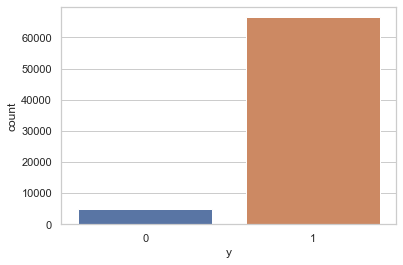

In [12]:
sns.countplot(x='y',data=train)
plt.show()

In [13]:
count_no_human = len(train[train['y']==0])
count_human = len(train[train['y']==1])
pct_of_no_human = count_no_human/(count_no_human+count_human)
print("\033[1m percentage of no human is", pct_of_no_human*100)
pct_of_human = count_human/(count_no_human+count_human)
print("\033[1m percentage of human", pct_of_human*100)

 percentage of no human is 6.951055608444867
 percentage of human 93.04894439155514


Our classes are imbalanced, and the ratio of no-human to human instances is 7:93.

# Create dummy variables

That is variables with only two values, zero and one.

In [14]:
cat_vars=['geolocation_type','geolocation_id','sensor_id','snr_type','date_index']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(train[var], prefix=var)
    train1=train.join(cat_list)
    train=train1
    
cat_vars=['geolocation_type','geolocation_id','sensor_id','snr_type','date_index']
train_vars=train.columns.values.tolist()
to_keep=[i for i in train_vars if i not in cat_vars]


cat_vars=['geolocation_type','geolocation_id','sensor_id','snr_type','date_index']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(test[var], prefix=var)
    test1=test.join(cat_list)
    test=test1
    
cat_vars=['geolocation_type','geolocation_id','sensor_id','snr_type','date_index']
test_vars=test.columns.values.tolist()
to_keep=[i for i in test_vars if i not in cat_vars]

Our final data columns will be:

In [15]:
train_final=train[to_keep]
train_final.columns.values

test_final=test[to_keep]

In [16]:
train1 = train_final.copy()
train1.drop(['segment_id'], axis=1, inplace=True)

test1 = test_final.copy()
test1.drop(['segment_id'], axis=1, inplace=True)

# Over-sampling using SMOTE

With our training data created, I’ll up-sample the default using the SMOTE algorithm (Synthetic Minority Oversampling Technique). At a high level, SMOTE:

1. Works by creating synthetic samples from the minor class (default) instead of creating copies.
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

We are going to implement SMOTE in Python.

In [17]:
X_train = train1.loc[:, train1.columns != 'y']
y_train = train1.loc[:, train1.columns == 'y']
y_train=y_train.astype('int')

from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=47)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("\033[1m length of oversampled data is ",len(os_data_X))
print("\033[1m Number of no human in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("\033[1m Number of human",len(os_data_y[os_data_y['y']==1]))
print("\033[1m Proportion of no human data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("\033[1m Proportion of human data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

 length of oversampled data is  132926
 Number of no human in oversampled data 66463
 Number of human 66463
 Proportion of no human data in oversampled data is  0.5
 Proportion of human data in oversampled data is  0.5


Now we have a perfect balanced data! You may have noticed that I over-sampled only on the training data, because by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations, therefore, no information will bleed from test data into the model training.

In [18]:
cols=columns

In [19]:
X_train=os_data_X[cols]
y_train=os_data_y['y']

In [20]:
X_test=test1[cols]
y_test=test1['y']
y_test=y_test.astype('int')

# Decision Tree Model Fitting

In [21]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=47)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=47, splitter='best')

### Predicting the test set results and calculating the accuracy

In [22]:
from sklearn import metrics

y_pred = tree.predict(X_test)
print("\033[1m Accuracy of logistic regression classifier on training set:", "{:.4f}".format(tree.score(X_train, y_train)))
print("\033[1m Accuracy of logistic regression classifier on test set:", "{:.4f}".format(tree.score(X_test, y_test)))

 Accuracy of logistic regression classifier on training set: 0.9999
 Accuracy of logistic regression classifier on test set: 0.9993


# Cross Validation

Cross validation attempts to avoid overfitting while still producing a prediction for each observation dataset. We are using 10-fold Cross-Validation to train our model.

In [23]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=47)
modelCV = tree
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("\033[1m 10-fold cross validation average accuracy:", "{:.4f}".format((results.mean())))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


 10-fold cross validation average accuracy: 0.9995


# Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 2438     8]
 [   17 32719]]


In [25]:
print("\033[1m The result is telling us that we have: ",(confusion_matrix[0,0]+confusion_matrix[1,1]),"correct predictions.")
print("\033[1m The result is telling us that we have: ",(confusion_matrix[0,1]+confusion_matrix[1,0]),"incorrect predictions.")
print("\033[1m We have a total predictions of: ",(confusion_matrix.sum()))

 The result is telling us that we have:  35157 correct predictions.
 The result is telling us that we have:  25 incorrect predictions.
 We have a total predictions of:  35182


# Compute precision, recall, F-measure and support

To quote from Scikit Learn:

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2446
           1       1.00      1.00      1.00     32736

    accuracy                           1.00     35182
   macro avg       1.00      1.00      1.00     35182
weighted avg       1.00      1.00      1.00     35182



### Interpretation:

In [27]:
#calculate Accuracy, how often is the classifier correct?
print("Accuracy of decision tree model:", "{:.2%}".format(metrics.accuracy_score(y_test, y_pred)))
print("Well, you got a classification rate of", "{:.2%}".format(metrics.accuracy_score(y_test, y_pred)))
#calculate Precision
print("\nPrecision of decision tree model:", "{:.2%}".format(metrics.precision_score(y_test, y_pred)))
print("Precision: Precision is about being precise, i.e., how precise our model is. In other words, we can say, when a model makes a prediction, how often it is correct. In our prediction case, when our decision tree model predicted a loan is about to default, that loan actually defaulted", "{:.2%}".format(metrics.precision_score(y_test, y_pred)) ,"of the time.")
#calculate Recall
print("\nRecall of decision tree model:", "{:.2%}".format(metrics.recall_score(y_test, y_pred)))
print("Recall: If there is a loan that defaulted present in the test set and our decision tree model can identify it", "{:.2%}".format(metrics.recall_score(y_test, y_pred)) ,"of the time.")

Accuracy of decision tree model: 99.93%
Well, you got a classification rate of 99.93%

Precision of decision tree model: 99.98%
Precision: Precision is about being precise, i.e., how precise our model is. In other words, we can say, when a model makes a prediction, how often it is correct. In our prediction case, when our decision tree model predicted a loan is about to default, that loan actually defaulted 99.98% of the time.

Recall of decision tree model: 99.95%
Recall: If there is a loan that defaulted present in the test set and our decision tree model can identify it 99.95% of the time.


# ROC Curve

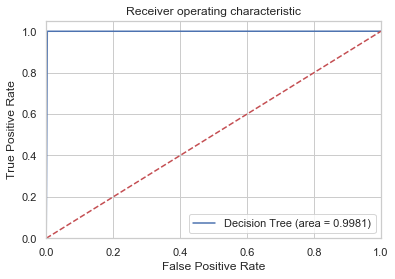

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label= 'Decision Tree (area = %0.4f)' % tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Decision Tree_ROC')
plt.show()

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

# ROC AUC Conclusion

In [29]:
print("\033[1m The ROC AUC score using the Decision Tree algorithm is:", "{:.2%}".format(tree_roc_auc))

 The ROC AUC score using the Decision Tree algorithm is: 99.81%
